In [20]:
%%javascript

# Bind cmd-shift-d to duplicate line of code
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('cmd-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

__Universal Robot Control__

In [21]:
import urx
import time, pickle
import numpy as np
import math3d as m3d

In [22]:
robot = urx.Robot("10.42.0.162", use_rt=True)

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 69
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1093
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


In [23]:
robot.set_digital_out(0, 1)
time.sleep(1)
robot.set_digital_out(0, 0)

In [24]:
robot.set_tcp((0, 0, 0.05, 0, 0, 0)) #ckeck Installation tab

In [25]:
robot.translate((0, 0, -0.05), acc=0.05, vel=0.05) #acceleration, velocity

<Transform:
<Orientation: 
array([[-0.90843722, -0.41479261, -0.0518547 ],
       [-0.41341101,  0.90985155, -0.03551756],
       [ 0.0619125 , -0.01082817, -0.99802284]])>
<Vector: (0.36802, 0.06916, 0.27562)>
>

In [26]:
robot.translate_tool((0, 0, -0.03), acc=0.05, vel=0.05)

<Transform:
<Orientation: 
array([[-0.90849622, -0.41472993, -0.05131952],
       [-0.4133465 ,  0.90987602, -0.03564123],
       [ 0.06147588, -0.01116718, -0.9980461 ]])>
<Vector: (0.36953, 0.07022, 0.30572)>
>

In [27]:
robot.get_pose()

<Transform:
<Orientation: 
array([[-0.90849645, -0.41470686, -0.05150172],
       [-0.413326  ,  0.90988828, -0.03556589],
       [ 0.06161023, -0.01102448, -0.9980394 ]])>
<Vector: (0.36956, 0.07025, 0.30565)>
>

In [28]:
robot.get_pos()

<Vector: (0.36955, 0.07023, 0.30565)>

In [29]:
robot.getl()

[0.36955379932658416,
 0.07023442903917888,
 0.3056360422446871,
 0.6538725838769602,
 -3.013251608057113,
 0.036877364953743164]

In [30]:
def save_current_pos(fname):
    p = robot.getl()
    np.savetxt(fname, np.array(p))
       

def move_to_pos(fname, *args, **kwargs):
    p = np.loadtxt(fname)
    robot.movel(p, *args, **kwargs)
    
def print_pos(fname):
    p = np.loadtxt(fname)
    print(p)
    

In [31]:
# p = np.array(robot.getl())
# p[0] = x_robot
# p[1] = y_robot
# robot.movel(p, vel=0.05, acc=0.05)

NameError: name 'x_robot' is not defined

In [32]:
move_to_pos("in", vel=0.05, acc=0.05)

In [ ]:
robot.getl()

In [14]:
robot.z -= 0.05 #1 hour 10 minutes up to this point

In [33]:
p = robot.get_pos()

In [34]:
p.array

array([ 0.40195527,  0.08054975,  0.32084372])

In [ ]:
m3d.Vector(p.array)

In [23]:
import threading
from IPython.display import display
import ipywidgets as widgets
import time

fw = widgets.HTML(
    value='',
    placeholder='No data',
    description='Force:',
)

def observe_force(fw):
    while True:
        fw.value = "<br>".join(["{0:5} {1:7.3f}".format(*c) for c in 
                                zip("x y z rx ry rz".split(), robot.get_tcp_force())])

thread = threading.Thread(target=observe_force, args=(fw,))
display(fw)
thread.start()



In [22]:
robot.get_tcp_force().__str__()

'[-3.97859526  6.43992056 -8.69520178 -1.40950517 -0.5001353   0.58747625]'

__Here starts CV__

In [36]:
%matplotlib notebook

import cv2 #pip install opencv-python
import matplotlib.pyplot as plt
import signal, time
import numpy as np
from numpy import linalg
#to check: cv2.getBuildInformation()
print (*filter(lambda s: "FFMPEG" in s, cv2.getBuildInformation().split("\n")))
#for opencv with ffmpeg in conda
#https://github.com/conda-forge/opencv-feedstock/
#pip uninstall opencv
#pip uninstall opencv-python
#conda unistall opencv
#conda install conda=4.0.11
#conda config --add channels conda-forge
#conda install opencv


    FFMPEG:                      YES


In [37]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [38]:
%%bash
ls /dev | grep video

video0
video1


In [39]:
vc = cv2.VideoCapture(1) #0 for the first webcam, 1 for the second..

In [98]:
def imshow(frame, from_color_space='bgr'):
    plt.figure()
    if from_color_space == 'bgr':
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    elif from_color_space == 'hsv':
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)    # makes the blues image look real colored
    else:
        rgb_frame=frame
    webcam_preview = plt.imshow(rgb_frame)

def online_view():
    plt.ion()

    if vc.isOpened(): # try to get the first frame
        is_capturing, frame = vc.read()
        imshow(frame)   
    else:
        is_capturing = False

    signal.signal(signal.SIGINT, signal_handler)
    is_interrupted = False
    while is_capturing:
        is_capturing, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        webcam_preview.set_data(frame)
        plt.draw()

        try:    # Avoids a NotImplementedError caused by `plt.pause`
            plt.pause(0.05)
        except Exception:
            pass
        if is_interrupted:
            vc.release()
            break
    
def get_frame():
    timeout = time.time() + 0.1
    while time.time() < timeout:
        if vc.isOpened(): # try to get the first frame
            is_capturing, frame = vc.read()
        else:
            raise (Exception("Unable to capture"))
    return frame


#frame = get_frame()
#imshow(frame)

#online_view()

<IPython.core.display.Javascript object>


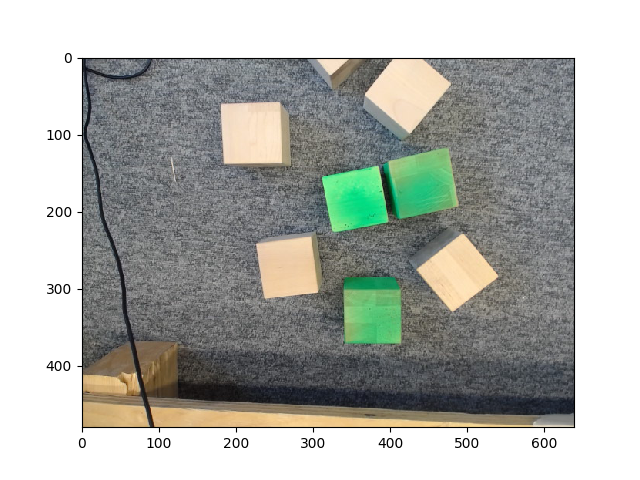

In [99]:
frame = get_frame()
imshow(frame)

__The blob detection__

In [46]:
move_to_pos('in', acc=0.05, vel=0.05)

<IPython.core.display.Javascript object>


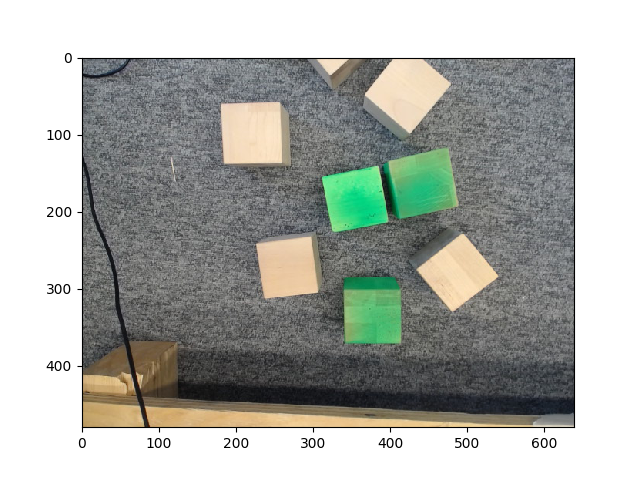

<IPython.core.display.Javascript object>


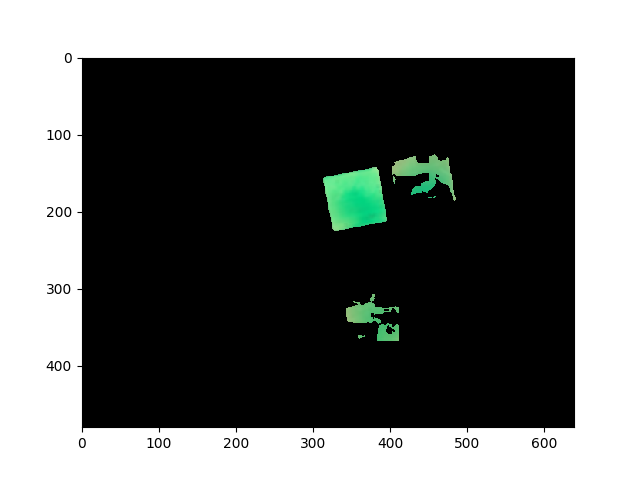

<IPython.core.display.Javascript object>


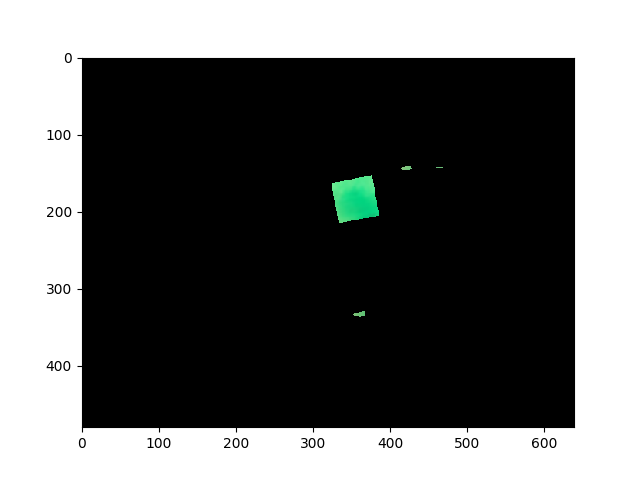

In [100]:
# Read image
# im = cv2.imread("detection/cubes_4.png")
im = get_frame()
cv2.imwrite('test.png', im)

imshow(im)

# Blur image to remove noise
im = cv2.GaussianBlur(im, (5,5), 40)

# imshow(im)

hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

greenMin = (30, 75, 186) #./range-detector.py -i test.png -f HSV
greenMax = (88, 255, 255)

# Sets pixels to white if in purple range, else will be set to black150
mask = cv2.inRange(hsv, greenMin, greenMax)

# Bitwise-AND of mask and purple only image - only used for display
masked = cv2.bitwise_and(im, im, mask= mask)

imshow(masked)

# dilate makes the in range areas larger
mask = cv2.erode(mask, None, iterations=8)

# mask = cv2.dilate(mask, None, iterations=8)


# Bitwise-AND of mask and purple only image - only used for display
masked = cv2.bitwise_and(im, im, mask= mask)

imshow(masked)

22
30.016761779785156
47.3216552734375
49.751983642578125
50.91683578491211
53.07551574707031
54.81113815307617


<IPython.core.display.Javascript object>


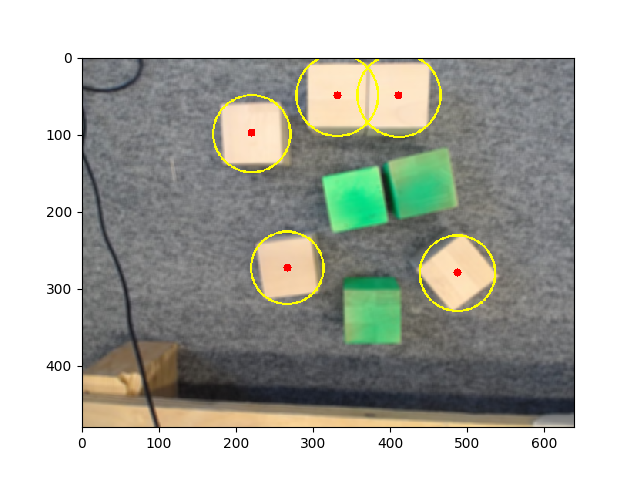

In [107]:
pts = []

# find contours in the mask and initialize the current
# (x, y) center of the ball
cnts = cv2.findContours(mask.copy(), cv2.RETR_LIST,
    cv2.CHAIN_APPROX_SIMPLE)[-2]
center = None

print (len(cnts))

# only proceed if at least one contour was found
for c in cnts:
    # find the largest contour in the mask, then use
    # it to compute the minimum enclosing circle and
    # centroid
#     c = max(cnts, key=cv2.contourArea)
    ((x, y), radius) = cv2.minEnclosingCircle(c)

    # only proceed if the radius meets a minimum size
    if radius > 25 and radius < 200:
        print (radius)
        
        M = cv2.moments(c)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        if center[1] > 400:
            continue
        # draw the circle and centroid on the frame,
        # then update the list of tracked points
        cv2.circle(im, (int(x), int(y)), int(radius),
            (0, 255, 255), 2)
        cv2.circle(im, center, 5, (0, 0, 255), -1)

        # update the points queue
        pts.append(center)

imshow(im)

<IPython.core.display.Javascript object>


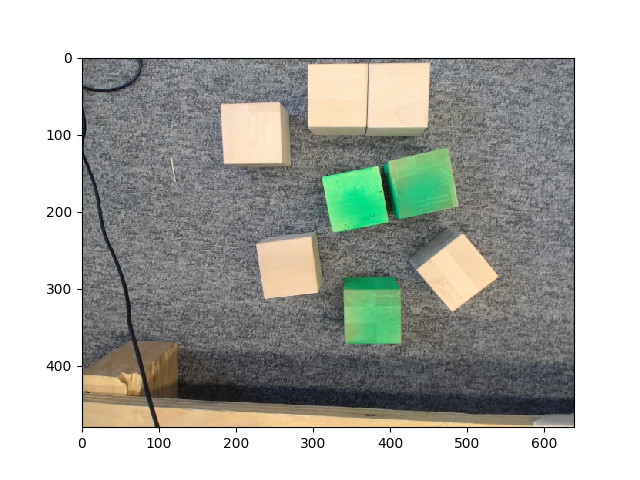

<IPython.core.display.Javascript object>


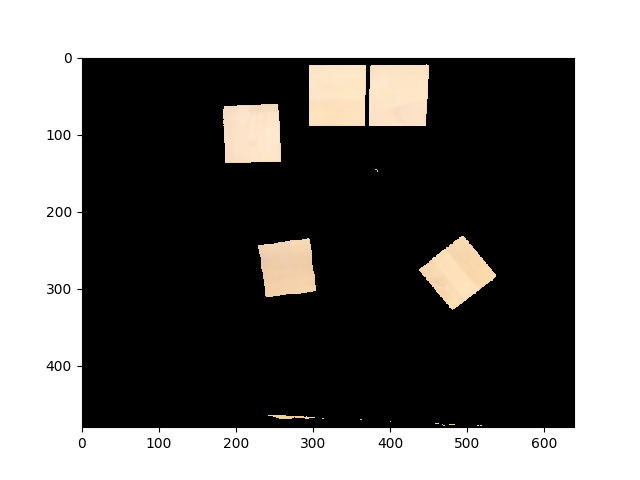

<IPython.core.display.Javascript object>


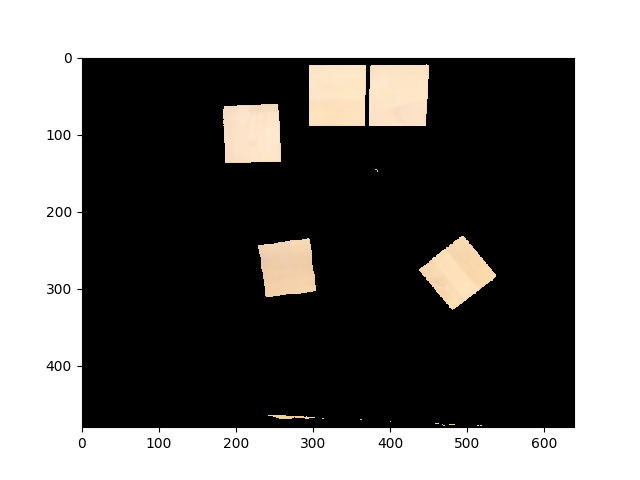

In [106]:
# Read image
# im = cv2.imread("detection/cubes_4.png")
im = get_frame()
cv2.imwrite('test.png', im)

imshow(im)

# Blur image to remove noise
im = cv2.GaussianBlur(im, (5,5), 10)

# imshow(im)

hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

pinkMin = (11, 45, 233) #./range-detector.py -i test.png -f HSV
pinkMax = (176, 93, 255)

# Sets pixels to white if in purple range, else will be set to black150
mask = cv2.inRange(hsv, pinkMin, pinkMax)

# Bitwise-AND of mask and purple only image - only used for display
masked = cv2.bitwise_and(im, im, mask= mask)

imshow(masked)

# dilate makes the in range areas larger
mask = cv2.erode(mask, None, iterations=0)

# mask = cv2.dilate(mask, None, iterations=8)


# Bitwise-AND of mask and purple only image - only used for display
masked = cv2.bitwise_and(im, im, mask= mask)

imshow(masked)

In [64]:
pts

[(376, 339), (439, 160), (357, 165), (291, 67), (377, 20)]

In [ ]:
# save_current_pos('green')

In [ ]:
move_to_pos('in', acc=0.05, vel=0.05)

In [44]:
# save_current_pos('white')